# Hands Classification
We have recording of hands in 3 different scenarios.  
1. Spontan- two hand moving freely.
2. Sync- two hand moving, trying to be synchronized.
3. Alone- one hand moving freely.  

Our target is to classify hands to one of the categories according to their recorded movements and position. 

In [1]:
#Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
#constant randoms in different runs
np.random.seed(0)

In [2]:
#understanding the data
#example data:
Evyatar_spon=pd.read_csv('Datasets/Hands/Training/Evyatar Cohen/Evyatar636771052727603804Spontan.csv')

In [3]:
Evyatar_spon.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,335.9984,128556,right,2,128.63570,224.0294,-12.29588,-18.26243,-140.54450,-117.57790,...,-1.588251,177.5125,173.5658,-14.569630,276.8753,-33.68264,91.61740,0.0,1.250576,0.0
1,335.9984,128556,left,2,-93.24845,143.9423,-37.81597,-109.09820,240.38980,-67.62959,...,0.873458,-147.0455,109.9380,-5.326688,-329.8577,-34.41571,93.88171,0.0,0.014736,0.0
2,336.0150,128558,right,2,129.15550,221.9923,-15.00181,47.36464,-64.25022,-168.85850,...,-1.528183,177.7894,171.1952,-14.677850,276.0645,-33.15913,97.88171,0.0,1.069930,0.0
3,336.0150,128558,left,2,-94.86554,148.5542,-39.00158,-80.99012,278.60220,-66.79356,...,0.879703,-148.2022,113.0909,-7.375025,-326.9279,-39.97873,85.98000,0.0,0.000000,0.0
4,336.0315,128560,right,2,129.87070,220.7944,-18.38681,35.05422,-84.74242,-205.72030,...,-1.461710,178.3730,169.9159,-15.246240,276.1767,-30.72506,104.13920,0.0,0.916969,0.0


In [4]:
#parameters
Evyatar_spon.loc[0].index

Index(['Time', ' Frame ID', ' Hand Type', ' # hands', ' Position X',
       ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength'],
      dtype='object')

In [5]:
# frames per second
Evyatar_spon[(Evyatar_spon['Time']>336) & (Evyatar_spon['Time']<337)]

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
2,336.0150,128558,right,2,129.15550,221.9923,-15.001810,47.364640,-64.25022,-168.85850,...,-1.528183,177.7894,171.19520,-14.677850,276.0645,-33.159130,97.88171,0.0,1.069930,0.0
3,336.0150,128558,left,2,-94.86554,148.5542,-39.001580,-80.990120,278.60220,-66.79356,...,0.879703,-148.2022,113.09090,-7.375025,-326.9279,-39.978730,85.98000,0.0,0.000000,0.0
4,336.0315,128560,right,2,129.87070,220.7944,-18.386810,35.054220,-84.74242,-205.72030,...,-1.461710,178.3730,169.91590,-15.246240,276.1767,-30.725060,104.13920,0.0,0.916969,0.0
5,336.0315,128560,left,2,-95.16259,152.5339,-39.945700,-11.372930,232.80310,-53.32079,...,0.895820,-148.3343,115.92950,-9.437292,-322.0559,-44.423830,81.02193,0.0,0.000000,0.0
6,336.0481,128562,right,2,131.07210,219.2134,-22.055110,36.516350,-153.35370,-212.82590,...,-1.380241,179.5035,168.44820,-15.568560,276.6018,-31.228400,105.96400,0.0,0.798334,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,336.9594,128667,left,2,-76.96600,115.3488,8.684893,73.801640,-145.98930,-228.56920,...,1.000582,-139.3870,94.56170,36.730190,-369.6905,34.979000,123.28030,0.0,1.308134,0.0
118,336.9758,128669,right,2,140.29330,167.0396,-84.622220,-5.801827,241.61630,115.49260,...,-0.478863,174.9576,137.15860,-30.300330,234.9738,-9.023824,167.46080,0.0,0.000000,0.0
119,336.9758,128669,left,2,-75.37846,114.4238,4.754050,105.417400,-52.92049,-245.68910,...,0.981195,-137.1051,92.73209,33.644910,-365.1103,26.101660,121.13610,0.0,1.057895,0.0
120,336.9931,128671,right,2,140.24220,172.7196,-83.057540,15.962420,313.52550,94.47213,...,-0.474993,174.3975,140.33830,-29.841730,234.8062,-16.986300,159.05110,0.0,0.000000,0.0


Every ~1/60 second we have a "picture" of two hands- left and right.  
Each "picture" contains information about the hands placement, velocity and position.  
We will treat each pair of hands in a frame as one instance (single object).  
The "Alone" files will be paired with the file "HandRight.csv".  

## Data Importing

In [6]:
# data import
from os import listdir
folder=('Datasets/Hands/Training/')
Spon, Sync, Alone=list(), list(), list()
for participant in listdir(folder):
    for file in listdir(folder+participant+'/'):
        if file.endswith('Spontan.csv'):
            spon=pd.read_csv(folder+participant+'/'+file)
        elif file.endswith('Sync.csv'):
            sync=pd.read_csv(folder+participant+'/'+file)
        elif file.endswith('Alone.csv'):
            alone=pd.read_csv(folder+participant+'/'+file)
    Spon.append(spon)
    Sync.append(sync)
    Alone.append(alone)
print ('no. of df in Sync: '+str(len(Sync)))

no. of df in Sync: 9


We now have a list for every scenario.  
Test set:

In [7]:
# import test data
folder=('Datasets/Hands/Validation/')
Spon_test, Sync_test, Alone_test=list(), list(), list()
for participant in listdir(folder):
    for file in listdir(folder+participant+'/'):
        if file.endswith('Spontan.csv'):
            spon=pd.read_csv(folder+participant+'/'+file)
        elif file.endswith('Sync.csv'):
            sync=pd.read_csv(folder+participant+'/'+file)
        elif file.endswith('Alone.csv'):
            alone=pd.read_csv(folder+participant+'/'+file)
    Spon_test.append(spon)
    Sync_test.append(sync)
    Alone_test.append(alone)
print ('no. of df in Spon_test: '+str(len(Spon_test)))

no. of df in Spon_test: 3


We pair each "Alone" dataset with given right hand dataset.

In [8]:
right_hand=pd.read_csv("Datasets/Hands/HandRight.csv")
right_hand.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


## Data Preprocessing

### Search for NaN values, crop first 7 seconds

We will remove the first 7 seconds from each recording (time to get synchronized).

In [9]:
print('Example df length before: '+str(len(Alone[1])))# frames in Alone second dataframe
for scenario in (Spon,Sync,Alone):
    for df in scenario:
        df.drop(range(2*6*7),inplace=True)
print('Example df length after: '+str(len(Alone[1])))

Example df length before: 4575
Example df length after: 4491


In [10]:
# search for NaN values
c=0
for scenario in (Spon,Sync,Alone):
    for df in scenario:
        print('null in df no. '+ str(c)+': '+str(df.isna().sum().sum()))
        c+=1

null in df no. 0: 0
null in df no. 1: 0
null in df no. 2: 0
null in df no. 3: 0
null in df no. 4: 0
null in df no. 5: 0
null in df no. 6: 0
null in df no. 7: 0
null in df no. 8: 0
null in df no. 9: 0
null in df no. 10: 0
null in df no. 11: 0
null in df no. 12: 0
null in df no. 13: 0
null in df no. 14: 0
null in df no. 15: 0
null in df no. 16: 0
null in df no. 17: 0
null in df no. 18: 0
null in df no. 19: 0
null in df no. 20: 0
null in df no. 21: 0
null in df no. 22: 0
null in df no. 23: 0
null in df no. 24: 0
null in df no. 25: 0
null in df no. 26: 0


We'll reapet the process for the test data and right hand data

In [11]:
# test data
print('length before reduce: '+str(len(Spon_test[0])))
# remove first 7 seconds and count NaN
c=0
for scenario in (Spon_test,Sync_test,Alone_test):
    for df in scenario:
        df.drop(range(2*6*7),inplace=True)
        print('null in df no. '+ str(c)+': '+str(df.isna().sum().sum()))
        c+=1
print('length after reduce: '+str(len(Spon_test[0])))

length before reduce: 8969
null in df no. 0: 0
null in df no. 1: 0
null in df no. 2: 0
null in df no. 3: 0
null in df no. 4: 0
null in df no. 5: 0
null in df no. 6: 0
null in df no. 7: 0
null in df no. 8: 0
length after reduce: 8885


In [12]:
# right hand data
print('length before reduce: '+str(len(right_hand)))
right_hand.drop(range(2*6*7),inplace=True)
print('null in right_hand: '+str(right_hand.isna().sum().sum()))
print('length after reduce: '+str(len(right_hand)))

length before reduce: 4812
null in right_hand: 2304
length after reduce: 4728


We have NaN values in right_hand, we need to take care of them.

In [13]:
# locate NaN values
right_hand.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

If the NaN values are in the same frame, we can gust drop them, losing 384 frames.  
Otherwise we will need more data.

In [14]:
print('right_hand shape with NaN: '+str(right_hand.shape))
print('right_hand shape without NaN: '+str(right_hand.dropna().shape))
print ('difference: '+str(right_hand.shape[0]-right_hand.dropna().shape[0]))

right_hand shape with NaN: (4728, 22)
right_hand shape without NaN: (4344, 22)
difference: 384


Luckily, we only have only 384 frames with missing data, we will discard them.

In [15]:
right_hand=right_hand.dropna()
right_hand.shape

(4344, 22)

### Split train-validation sets
To avoid overfitting the models we will use validation dataset that the model didn't see in order to score different models. The model with the highest validation score will be our final model.  
We will train the final model on the full training data and record the final score on the test set.
We will take the validation data from the end of every train data list. The validation will be done on person the system has yet to see therefore the score will approximate the score on the test set.

In [16]:
#split validation set
f_Sync,f_Spon,f_Alone=Sync,Spon,Alone#save full datasets for final training
Sync=f_Sync[:8]#train data
Sync_val=f_Sync[8]#val data- DATAFRAME! NOT A LIST
Spon, Spon_val=f_Spon[:8],f_Spon[8]
Alone, Alone_val=f_Alone[:8],f_Alone[8]

In [17]:
Sync_val

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
84,782.7878,61321,left,2,-87.12481,232.9141,20.870510,160.46130,-337.67720,71.314360,...,2.641243,-124.4320,227.9077,-40.50225,-349.1523,97.92675,-90.08583,0.0,0.230727,0.0
85,782.7878,61321,right,2,90.66110,166.5023,116.351000,10.84154,-93.23019,38.813340,...,-2.442218,139.5072,158.7623,61.82096,321.8885,18.64640,-68.39959,0.0,0.233446,0.0
86,782.8218,61324,left,2,-83.41718,220.9065,20.525340,80.96638,-324.09010,3.225212,...,2.584996,-124.5254,215.5990,-38.39585,-344.4787,74.60229,-78.51043,0.0,0.000000,0.0
87,782.8218,61324,right,2,90.99130,163.0528,117.477900,20.09656,-87.01977,26.601470,...,-2.432716,140.5878,157.9306,63.32932,328.5499,25.07263,-66.62342,0.0,0.342637,0.0
88,782.8560,61327,left,2,-81.36111,209.6189,21.825730,32.39335,-313.71990,39.966430,...,2.527875,-125.6452,202.0646,-34.61309,-348.8363,62.84356,-60.79215,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,856.2631,67309,right,2,101.91230,212.0264,42.535680,79.95810,113.41030,190.771400,...,-0.574317,131.8590,149.6264,66.09853,283.6185,-58.03491,95.29868,0.0,0.000000,0.0
4496,856.2958,67311,left,2,-81.57359,183.5054,-7.185198,-63.24731,121.75270,62.959700,...,0.459446,-109.7250,130.7078,34.03360,-295.5957,-14.97817,140.02630,0.0,0.000000,0.0
4497,856.2958,67311,right,2,103.84750,214.7484,47.070820,61.11773,95.13531,155.745300,...,-0.612753,134.0416,151.5924,68.17693,288.9688,-54.13820,94.23959,0.0,0.000000,0.0
4498,856.3295,67314,left,2,-84.05124,187.8450,-5.172269,-57.17249,109.20360,58.481460,...,0.434273,-109.5167,131.6489,33.32945,-282.9649,-31.35462,135.07610,0.0,0.000000,0.0


We have the last person in the train set as validation data.

### Reorganizing the data frames
We want to pair together left and right hand from the same frame.

### 2 hands scenarios demo
We split the dataset and merge it horizontally

In [18]:
# the dataframe we will demonstrate on
demo=sync.copy()
demo.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
84,925.3400,60509,left,2,-121.3679,284.9276,71.08919,-37.52761,78.14517,32.94556,...,1.521496,-167.1657,227.7851,67.58211,-335.6783,38.53807,130.78630,0.0,0.328604,0.0
85,925.3400,60509,right,2,142.1444,271.0127,74.83476,-36.38242,-63.54549,54.77497,...,-1.401698,192.8051,217.4485,75.04996,373.2006,28.74548,82.42117,0.0,0.027603,0.0
86,925.3743,60511,left,2,-122.7052,287.0048,72.01142,-49.97677,69.69836,35.03852,...,1.522061,-168.4623,229.8258,68.45575,-334.5794,38.19341,130.80850,0.0,0.332486,0.0
87,925.3743,60511,right,2,141.2431,269.0698,76.03043,-35.50513,-88.49073,44.93065,...,-1.403901,191.8715,215.4569,76.01191,377.1630,31.49922,81.69724,0.0,0.045244,0.0
88,925.4076,60513,left,2,-124.1146,288.3193,72.90015,-46.41800,35.69813,28.18376,...,1.511062,-170.4284,231.5497,69.74766,-338.1897,41.28901,131.89810,0.0,0.360908,0.0


In [19]:
demo[' Hand Type'].value_counts()

right    2204
left     2158
Name:  Hand Type, dtype: int64

The data isn't complete. We will correct that when merging the right and left data- we will only include frames which have both hands.

In [20]:
#split dataset
demo_left=demo[demo[' Hand Type']=='left']
demo_right=demo[demo[' Hand Type']=='right']
demo_left.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
84,925.3400,60509,left,2,-121.3679,284.9276,71.08919,-37.52761,78.14517,32.945560,...,1.521496,-167.1657,227.7851,67.58211,-335.6783,38.53807,130.7863,0.0,0.328604,0.0
86,925.3743,60511,left,2,-122.7052,287.0048,72.01142,-49.97677,69.69836,35.038520,...,1.522061,-168.4623,229.8258,68.45575,-334.5794,38.19341,130.8085,0.0,0.332486,0.0
88,925.4076,60513,left,2,-124.1146,288.3193,72.90015,-46.41800,35.69813,28.183760,...,1.511062,-170.4284,231.5497,69.74766,-338.1897,41.28901,131.8981,0.0,0.360908,0.0
90,925.4398,60516,left,2,-125.3973,287.9051,73.72894,-14.55321,-53.31699,12.755390,...,1.495221,-172.7207,231.9361,71.27187,-352.0691,53.22682,135.3253,0.0,0.382371,0.0
92,925.4729,60518,left,2,-125.1278,284.3668,73.64545,13.44731,-139.13820,-5.644237,...,1.492570,-173.1618,229.0355,71.46091,-360.6429,60.20063,138.9244,0.0,0.389056,0.0


In [21]:
# merge horizontally, only hands in the same frame (inner)
demo2=pd.merge(demo_left,demo_right,on=['Time',' Frame ID',' # hands'],how='inner')
demo2

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,925.3400,60509,left,2,-121.36790,284.9276,71.08919,-37.52761,78.14517,32.945560,...,-1.401698,192.8051,217.4485,75.04996,373.2006,28.74548,82.42117,0.0,0.027603,0.0
1,925.3743,60511,left,2,-122.70520,287.0048,72.01142,-49.97677,69.69836,35.038520,...,-1.403901,191.8715,215.4569,76.01191,377.1630,31.49922,81.69724,0.0,0.045244,0.0
2,925.4076,60513,left,2,-124.11460,288.3193,72.90015,-46.41800,35.69813,28.183760,...,-1.403654,190.4933,211.9839,76.95097,379.3175,31.64314,82.27242,0.0,0.077169,0.0
3,925.4398,60516,left,2,-125.39730,287.9051,73.72894,-14.55321,-53.31699,12.755390,...,-1.405593,190.5499,209.6013,78.05990,383.9880,34.35482,86.77981,0.0,0.118110,0.0
4,925.4729,60518,left,2,-125.12780,284.3668,73.64545,13.44731,-139.13820,-5.644237,...,-1.404291,189.7028,206.5573,78.37885,386.9746,35.72657,88.69302,0.0,0.124140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,998.7513,66216,left,2,-98.32814,314.4973,75.12682,41.16818,115.85070,27.614590,...,-1.447439,156.7337,255.0919,101.90250,341.0338,65.01146,125.50060,0.0,0.000000,0.0
2154,998.7836,66219,left,2,-97.31071,319.5955,76.22157,31.36302,143.96100,30.502050,...,-1.447845,157.5847,259.1192,102.11500,336.8353,64.01215,123.47900,0.0,0.000000,0.0
2155,998.8158,66221,left,2,-96.74767,323.8981,76.98316,27.14988,185.62180,33.741870,...,-1.436827,159.1932,263.2726,102.53110,332.9102,62.99343,121.62640,0.0,0.000000,0.0
2156,998.8495,66224,left,2,-95.67720,329.8123,78.13316,47.37696,118.31670,24.152470,...,-1.418975,163.0329,269.7217,103.07490,340.7914,72.96347,121.57070,0.0,0.024162,0.0


We have the data of both hands under the same frame.  
Data with "_x" describes the left hand and data with "_y" describes the right hand.

In [22]:
print('demo2 length: '+str(demo2[' # hands'].size))
print('demo2 [# hands] value count: \n'+str(demo2[' # hands'].value_counts()))

demo2 length: 2158
demo2 [# hands] value count: 
2    2158
Name:  # hands, dtype: int64


We removed all single hand data.

### Alone scenarios
The method above will work for 2 hands data, in "Alone" datasets we need to pair the "right_hand" dataset.  
However, if we just merged every "Alone" with "right_hand" the machine will be able to classify them easily.  
To avoid such problem, we will split "right_hand" to 3 subsets, train data, validation data and test data (with 1 sec distance between to avoid data leak), we will create a random right_hand dataset to accompany each Alone dataset. The right_hand dataset will have the same length as the corresponding Alone dataset, and will be created randomly from the relevant data (train or test data).  
We will achive that by creating lists of random indexes for every Alone dataset and create the right_hand dataset according to them.

In [23]:
# split "right_hand"
right_hand_train_data=right_hand.iloc[:3000]
# 1 sec interval
right_hand_val_data=right_hand.iloc[3060:3460]
right_hand_test_data=right_hand.iloc[3520:]
right_hand_train_data.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
84,129.6882,15640,right,1,27.13876,207.4796,52.11142,41.588500,-76.60230,-101.7598,...,-0.265757,58.90767,202.2814,120.3888,236.1884,84.59581,286.1831,0.0,0.585902,0.0
85,129.7048,15642,right,1,27.54398,206.3630,49.93446,22.403330,-47.71859,-129.2814,...,-0.264195,59.17055,201.5768,118.2975,235.2411,83.32476,285.0026,0.0,0.557712,0.0
86,129.7208,15644,right,1,27.66292,206.4216,47.49265,0.895973,15.64516,-146.0183,...,-0.264369,59.23776,201.8046,115.9001,234.3763,83.89951,283.8558,0.0,0.546594,0.0
87,129.7375,15646,right,1,27.41630,207.3747,44.52312,-18.092530,54.98383,-178.6693,...,-0.265373,59.01835,202.4811,112.9170,233.1135,84.00522,281.5832,0.0,0.517014,0.0
88,129.7542,15648,right,1,26.98242,209.4798,41.54232,-26.689180,147.61150,-168.3345,...,-0.265294,58.52890,204.3822,109.9002,231.3450,81.18188,276.5166,0.0,0.467832,0.0


In [24]:
#create demo right hand dataframe
demo=pd.DataFrame()
recipe=np.random.randint(3000, size=len(Alone[3]))# create recipe for Alone[3]
for index in recipe:
    demo=demo.append(right_hand_train_data.iloc[index].copy())#create line for each left hand line
demo

,# hands,Elbow Pos Y,Elbow Pos Z,Elbow pos X,Frame ID,Grab Angle,Grab Strenth,Hand Type,Pinch Strength,Pitch,...,Position Z,Roll,Velocity X,Velocity Y,Velocity Z,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Yaw,Time
2816,1.0,22.003740,322.1707,181.958700,20849.0,0.998335,0.0,right,0.000000,0.451632,...,87.972540,-0.022126,77.28802,-7.132415,-308.451000,13.606850,157.56890,155.96540,-0.042926,174.8730
2691,1.0,-1.703353,249.9926,145.013800,20609.0,0.000000,0.0,right,0.000000,0.823625,...,0.204449,-0.034195,128.75170,-512.891600,-304.788500,31.844500,151.56740,55.21538,-0.116832,172.7899
1737,1.0,52.186940,303.1174,153.942300,18738.0,2.880009,1.0,right,0.615545,0.804581,...,71.898120,0.089243,-107.20090,180.616300,74.145390,68.462240,243.89270,126.50950,-0.254537,156.5618
919,1.0,89.407630,361.5245,108.309300,17231.0,3.141593,1.0,right,1.000000,0.462263,...,39.191720,0.123790,-132.94850,260.496600,-40.933380,12.545120,127.69400,109.73720,-0.090340,143.4827
847,1.0,20.220150,336.0565,154.969100,17106.0,2.587753,0.0,right,0.737045,0.670885,...,60.431630,0.251412,-52.33714,-292.352700,-3.553731,69.947100,168.43510,124.30890,0.241368,142.4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,1.0,41.260890,286.4287,128.080700,17433.0,0.111760,0.0,right,0.000000,0.505462,...,45.031520,-0.750595,-82.56967,396.170400,42.269700,26.943930,222.88080,109.37190,0.018528,145.2500
330,1.0,173.556700,229.3383,203.243500,16112.0,0.319363,0.0,right,0.000000,0.310827,...,6.256772,-0.022093,-40.31133,467.572000,106.362300,33.288750,306.94840,65.71410,-0.504606,133.7864
2519,1.0,-48.728000,285.4431,156.628100,20240.0,0.585126,0.0,right,0.000000,1.381479,...,157.148800,-0.065906,-106.63970,401.949400,-127.145300,9.360494,154.35570,178.04090,-0.437379,169.5907
3002,1.0,96.912740,341.7314,0.214948,21207.0,2.639150,0.0,right,0.021413,0.220966,...,2.812839,-2.680968,-22.85344,-117.348900,-22.146500,12.407840,92.34872,69.41825,0.414427,177.9711


Lastly, we will switch the 'Time' and 'Frame ID' columns to help with merging.  

In [25]:
#process explanation:
#drop 'Time' and Frame ID' from right hand data while reseting the index to avoid duplicates
dropped=demo.reset_index().drop(columns=['Time', ' Frame ID', 'index'])
dropped.head()

,# hands,Elbow Pos Y,Elbow Pos Z,Elbow pos X,Grab Angle,Grab Strenth,Hand Type,Pinch Strength,Pitch,Position X,Position Y,Position Z,Roll,Velocity X,Velocity Y,Velocity Z,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Yaw
0,1.0,22.003740,322.1707,181.9587,0.998335,0.0,right,0.000000,0.451632,-3.842576,188.1969,87.972540,-0.022126,77.28802,-7.132415,-308.451000,13.60685,157.5689,155.96540,-0.042926
1,1.0,-1.703353,249.9926,145.0138,0.000000,0.0,right,0.000000,0.823625,14.252420,202.4830,0.204449,-0.034195,128.75170,-512.891600,-304.788500,31.84450,151.5674,55.21538,-0.116832
2,1.0,52.186940,303.1174,153.9423,2.880009,1.0,right,0.615545,0.804581,46.002970,293.9568,71.898120,0.089243,-107.20090,180.616300,74.145390,68.46224,243.8927,126.50950,-0.254537
3,1.0,89.407630,361.5245,108.3093,3.141593,1.0,right,1.000000,0.462263,-3.794198,153.4998,39.191720,0.123790,-132.94850,260.496600,-40.933380,12.54512,127.6940,109.73720,-0.090340
4,1.0,20.220150,336.0565,154.9691,2.587753,0.0,right,0.737045,0.670885,72.368970,210.8473,60.431630,0.251412,-52.33714,-292.352700,-3.553731,69.94710,168.4351,124.30890,0.241368


In [26]:
#extracting time and 'Frame ID' from the corresponding Alone data
time_ID=Alone[3][['Time', ' Frame ID']].copy()
#resetting index for concatenating with 'dropped'
time_ID=time_ID.reset_index().drop(columns='index')
time_ID.head()

,Time,Frame ID
0,290.1505,34023
1,290.1664,34024
2,290.1835,34026
3,290.1996,34028
4,290.2164,34030


In [27]:
# our right hand dataset
pd.concat([time_ID, dropped], axis=1)

,Time,Frame ID,# hands,Elbow Pos Y,Elbow Pos Z,Elbow pos X,Grab Angle,Grab Strenth,Hand Type,Pinch Strength,...,Position Y,Position Z,Roll,Velocity X,Velocity Y,Velocity Z,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Yaw
0,290.1505,34023,1.0,22.003740,322.1707,181.958700,0.998335,0.0,right,0.000000,...,188.1969,87.972540,-0.022126,77.28802,-7.132415,-308.451000,13.606850,157.56890,155.96540,-0.042926
1,290.1664,34024,1.0,-1.703353,249.9926,145.013800,0.000000,0.0,right,0.000000,...,202.4830,0.204449,-0.034195,128.75170,-512.891600,-304.788500,31.844500,151.56740,55.21538,-0.116832
2,290.1835,34026,1.0,52.186940,303.1174,153.942300,2.880009,1.0,right,0.615545,...,293.9568,71.898120,0.089243,-107.20090,180.616300,74.145390,68.462240,243.89270,126.50950,-0.254537
3,290.1996,34028,1.0,89.407630,361.5245,108.309300,3.141593,1.0,right,1.000000,...,153.4998,39.191720,0.123790,-132.94850,260.496600,-40.933380,12.545120,127.69400,109.73720,-0.090340
4,290.2164,34030,1.0,20.220150,336.0565,154.969100,2.587753,0.0,right,0.737045,...,210.8473,60.431630,0.251412,-52.33714,-292.352700,-3.553731,69.947100,168.43510,124.30890,0.241368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,363.6728,42486,1.0,41.260890,286.4287,128.080700,0.111760,0.0,right,0.000000,...,263.6024,45.031520,-0.750595,-82.56967,396.170400,42.269700,26.943930,222.88080,109.37190,0.018528
4439,363.6898,42488,1.0,173.556700,229.3383,203.243500,0.319363,0.0,right,0.000000,...,324.9749,6.256772,-0.022093,-40.31133,467.572000,106.362300,33.288750,306.94840,65.71410,-0.504606
4440,363.7059,42489,1.0,-48.728000,285.4431,156.628100,0.585126,0.0,right,0.000000,...,225.8339,157.148800,-0.065906,-106.63970,401.949400,-127.145300,9.360494,154.35570,178.04090,-0.437379
4441,363.7227,42491,1.0,96.912740,341.7314,0.214948,2.639150,0.0,right,0.021413,...,112.3485,2.812839,-2.680968,-22.85344,-117.348900,-22.146500,12.407840,92.34872,69.41825,0.414427


We will pair those datasets with their Alone corresponding datasets to get 2-hands datasets.

In [28]:
# paired dataset example
right=pd.concat([time_ID, dropped], axis=1)
Alone[3].append(right,ignore_index=True)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,290.1505,34023,left,1.0,-33.07419,254.2497,23.241940,54.21996,-577.08650,-131.15690,...,1.576030,-89.653980,215.94370,16.05349,-264.564500,48.10490,-10.420780,0.0,0.564059,0.799974
1,290.1664,34024,left,1.0,-32.08050,248.4454,21.861620,114.74510,-670.24350,-159.39010,...,1.568583,-89.060520,210.61260,15.18296,-268.273900,46.98879,-8.781100,0.0,0.570904,0.755616
2,290.1835,34026,left,1.0,-30.47708,239.2094,19.146540,108.77610,-519.50810,-154.31970,...,1.551061,-88.469710,202.71480,13.50917,-276.099900,48.26530,-6.609064,0.0,0.549327,0.696177
3,290.1996,34028,left,1.0,-28.62491,231.8327,16.163330,83.55526,-337.71690,-161.35970,...,1.537723,-87.227700,196.09360,11.31284,-286.516500,56.57439,-5.504764,0.0,0.547002,0.760822
4,290.2164,34030,left,1.0,-27.14336,222.6850,13.447050,132.96110,-534.63560,-160.92060,...,1.529848,-85.900710,187.03040,9.34878,-295.193100,62.35886,-1.522220,0.0,0.662062,0.790702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8881,363.6728,42486,right,1.0,15.10360,263.6024,45.031520,-82.56967,396.17040,42.26970,...,0.018528,26.943930,222.88080,109.37190,128.080700,41.26089,286.428700,0.0,0.111760,0.000000
8882,363.6898,42488,right,1.0,-10.84456,324.9749,6.256772,-40.31133,467.57200,106.36230,...,-0.504606,33.288750,306.94840,65.71410,203.243500,173.55670,229.338300,0.0,0.319363,0.000000
8883,363.7059,42489,right,1.0,-10.27316,225.8339,157.148800,-106.63970,401.94940,-127.14530,...,-0.437379,9.360494,154.35570,178.04090,156.628100,-48.72800,285.443100,0.0,0.585126,0.000000
8884,363.7227,42491,right,1.0,43.06517,112.3485,2.812839,-22.85344,-117.34890,-22.14650,...,0.414427,12.407840,92.34872,69.41825,0.214948,96.91274,341.731400,0.0,2.639150,0.021413


### Repeating the process on all data frames

#### Alone scenarios
we will add the right hand data as shown in the example above.

In [29]:
#create right hand datasets with the same length, Time and Frame ID
def create_right_hand_for_left (right_hand_database, left_hand_dataframe):
    "create right hand datasets with the same length, Time and Frame ID as the left hand dataset"
    df=pd.DataFrame()
    recipe=np.random.randint(len(right_hand_database), size=len(left_hand_dataframe))# create recipe for left_hand_dataframe
    for index in recipe:
        df=df.append(right_hand_database.iloc[index].copy())# add lines
    # reset index
    df=df.reset_index().drop(columns=['Time', ' Frame ID', 'index'])
    # 'Time' and 'Frame ID' of the left hand
    time_ID=left_hand_dataframe[['Time', ' Frame ID']].copy()
    time_ID=time_ID.reset_index().drop(columns='index')# reset index
    # combine data
    df=pd.concat([time_ID, df], axis=1)
    return df

In [30]:
# create lists of right hand data
print('example df shape beafore: '+str(Alone[4].shape))
right_hand_train=[create_right_hand_for_left(right_hand_train_data,left_dataset) 
                  for left_dataset in Alone]
#val data
right_hand_val=create_right_hand_for_left(right_hand_val_data,Alone_val)# dataframe, not a list
# test data
right_hand_test=[create_right_hand_for_left(right_hand_test_data,left_dataset) 
                  for left_dataset in Alone_test]
print('no. of right hand training datasets: '+str(len(right_hand_train)))
print('no. of right hand test datasets: '+str(len(right_hand_test)))
print('example dataset:')
right_hand_train[3]
print('example df shape beafore: '+str(Alone[4].shape))


example df shape beafore: (4847, 22)
no. of right hand training datasets: 8
no. of right hand test datasets: 3
example dataset:
example df shape beafore: (4847, 22)


In [31]:
#combining Alone and right_hand data
print('example df shape beafore: '+str(Alone[4].shape))
Alone=[Alone[i].append(right_hand_train[i],ignore_index=True) for i in range(len(Alone))]
Alone_val=Alone_val.append(right_hand_val,ignore_index=True)
Alone_test=[Alone_test[i].append(right_hand_test[i],ignore_index=True) for i in range(len(Alone_test))]
print('example df shape after: '+str(Alone[4].shape))

example df shape beafore: (4847, 22)
example df shape after: (9694, 22)


#### 2 hands scenarios

In [32]:
#function that does the "2 hands scenarios" steps
def left_right_rehape (df):
    "pair together left and right hand from the same frame."
    left=df[df[' Hand Type']=='left'] # split
    right=df[df[' Hand Type']=='right']
    df=pd.merge(left,right,on=['Time',' Frame ID',' # hands'],how='inner') # merge horizontally
    return df 

In [33]:
# train data
print('Example df shape before: '+str(Sync[1].shape))# frames in Alone second dataframe
Spon = [left_right_rehape(df) for df in Spon]
Sync = [left_right_rehape(df) for df in Sync]
Alone = [left_right_rehape(df) for df in Alone]
print('Example df shape after: '+str(Sync[1].shape))

Example df shape before: (8970, 22)
Example df shape after: (4485, 41)


In [34]:
# val data
print('Example df shape before: '+str(Alone_val.shape))
Spon_val=left_right_rehape(Spon_val)
Sync_val=left_right_rehape(Sync_val)
Alone_val=left_right_rehape(Alone_val)
print('Example df shape after: '+str(Alone_val.shape))

Example df shape before: (4332, 22)
Example df shape after: (2166, 41)


In [35]:
# test data
print('Example df shape before: '+str(Sync_test[1].shape))# frames in Sync_test second dataframe
Spon_test = [left_right_rehape(df) for df in Spon_test]
Sync_test = [left_right_rehape(df) for df in Sync_test]
Alone_test = [left_right_rehape(df) for df in Alone_test]
print('Example df shape after: '+str(Sync_test[1].shape))

Example df shape before: (8881, 22)
Example df shape after: (4396, 41)


In [36]:
# process validation
nulls=0
for scenario in (Spon,Sync,Alone):# train data
    for df in scenario:
        nulls+=df.isna().sum().sum()
print ('NaN in train: '+str(nulls))
nulls=0
for df in (Spon_val,Sync_val,Alone_val):# val data
    nulls+=df.isna().sum().sum()
print ('NaN in val: '+str(nulls))
nulls=0
for scenario in (Spon_test,Sync_test,Alone_test):# test data
    for df in scenario:
        nulls+=df.isna().sum().sum()
print ('NaN in test: '+str(nulls))

NaN in train: 0
NaN in val: 0
NaN in test: 0


In [37]:
#example dataframe:
Alone[6]

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,581.5308,67418,left,1.0,-76.71217,169.7437,120.08610,29.847290,145.294000,-9.577309,...,-0.057279,-16.559840,156.41360,114.80200,140.91230,35.25548,300.9644,0.0,0.122396,0.0
1,581.5474,67420,left,1.0,-76.54177,172.8228,120.82230,11.390680,182.785000,38.781030,...,-0.006220,5.735185,161.90320,117.35960,153.39880,32.42252,305.7524,0.0,0.191291,0.0
2,581.5642,67422,left,1.0,-75.50815,175.9512,120.56280,33.162720,177.965400,-17.960370,...,0.383487,154.245900,154.69990,140.43310,116.20250,-58.29951,309.1911,0.0,0.309642,0.0
3,581.5805,67424,left,1.0,-75.60246,176.8827,118.29120,-21.255490,4.165794,-149.039100,...,-0.061132,16.706410,176.91780,97.47102,154.49740,68.01263,308.7380,0.0,0.181278,0.0
4,581.5973,67426,left,1.0,-75.99397,176.8511,116.31530,-16.953590,21.419040,-91.840780,...,-0.169294,14.418640,265.23520,110.12810,156.25270,114.15000,285.5070,0.0,0.021031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,655.0536,75897,left,1.0,-47.59903,169.5047,95.27844,49.218430,18.580460,-68.544970,...,-0.192023,63.783820,245.18890,138.72710,170.60390,93.68549,340.9989,0.0,0.628635,0.0
3806,655.0704,75898,left,1.0,-47.15852,169.6898,94.63470,50.373110,21.161710,-73.612840,...,-0.599588,60.949810,204.77190,75.79311,210.74390,141.73460,290.8141,0.0,0.433909,0.0
3807,655.0868,75900,left,1.0,-46.46194,170.0966,93.34528,33.703330,17.504740,-75.141840,...,-0.058155,79.551840,156.00980,132.27110,182.34880,103.04810,381.0203,0.0,0.553551,0.0
3808,655.1034,75902,left,1.0,-46.42885,170.2374,92.04515,-9.843105,8.646168,-71.796110,...,-0.004869,18.525410,83.27013,181.02190,72.72215,-96.43248,379.1018,0.0,0.558516,0.0


### Adding 'distance'
We want to add "distance" column which will determane the distance between the two hands.  
the distance in 3 axes is calculated as the root of the sum of the squared distance in each axis.  
For example, the distance between (1,1,1,) and (1,2,3) is $\sqrt{(1-1)^2+(1-2)^2+(1-3)^2}=\sqrt{5}$

In [38]:
# our example dataframe
Spon_val

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,600.0165,45314,left,2,-84.37640,157.7529,-16.00165,40.876340,101.109100,-1.073980,...,-2.559724,258.6872,242.1461,106.49200,384.9687,20.00741,53.41334,0.0,0.150314,0.045202
1,600.0511,45317,left,2,-84.05661,160.3753,-15.03982,4.309120,72.717670,-7.913699,...,-2.636580,257.8325,242.8422,105.92160,377.7732,20.52651,40.34788,0.0,0.256123,0.290471
2,600.0846,45320,left,2,-83.50819,161.5926,-13.89833,33.672330,-22.503000,62.624160,...,-2.640296,257.2766,242.7580,107.06370,373.1628,20.78875,33.51092,0.0,0.309418,0.341940
3,600.1182,45323,left,2,-81.88733,159.9530,-13.06402,30.234160,-31.048380,16.365450,...,-2.657700,256.0296,242.4853,108.26050,366.2163,20.38346,26.77651,0.0,0.348240,0.394976
4,600.1514,45326,left,2,-81.30766,159.2037,-12.18721,2.059324,-4.778836,32.587490,...,-2.676214,253.9939,241.1002,107.78910,365.2135,20.80329,23.01902,0.0,0.358740,0.380478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2078,673.4224,52505,left,2,-93.01819,221.5837,37.95346,93.660400,-705.109000,-58.953580,...,-0.651545,198.7744,148.9755,36.17215,429.8078,88.65751,136.27590,0.0,0.256132,0.000000
2079,673.4561,52509,left,2,-87.87977,207.0944,30.25084,161.308200,-332.783400,-239.552200,...,-0.555046,198.7646,147.6285,30.82009,424.2537,67.32506,129.28760,0.0,0.275538,0.000000
2080,673.4894,52512,left,2,-81.66566,203.9826,24.04028,240.809500,-160.562000,-222.444200,...,-0.491103,199.4005,147.6265,27.94176,413.8865,47.81111,132.77050,0.0,0.342347,0.000000
2081,673.5233,52516,left,2,-77.57621,198.9182,20.57973,127.002900,-218.657100,-80.403090,...,-0.452287,200.4651,148.9561,25.42753,400.5782,31.01108,139.27960,0.0,0.448368,0.000000


In [39]:
# (X1-X2)^2
(Spon_val[' Position X_x']-Spon_val[' Position X_y'])**2

0       100877.191977
1       100869.575792
2        99914.778327
3        98430.108279
4        96922.857129
            ...      
2078     57014.880753
2079     56795.502489
2080     55875.107282
2081     55740.806528
2082     55440.347326
Length: 2083, dtype: float64

In [40]:
# ((X1-X2)^2+(Y1-Y2)^2+(Z1-Z2)^2)^0.5
distance=((Spon_val[' Position X_x']-Spon_val[' Position X_y'])**2+#(X1-X2)^2
(Spon_val[' Position Y_x']-Spon_val[' Position Y_y'])**2+#(Y1-Y2)^2
(Spon_val[' Position Z_x']-Spon_val[' Position Z_y'])**2)**0.5#(Z1-Z2)^2

In [41]:
#insert the distance column
Spon_val['Distance']=distance
Spon_val

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Distance
0,600.0165,45314,left,2,-84.37640,157.7529,-16.00165,40.876340,101.109100,-1.073980,...,258.6872,242.1461,106.49200,384.9687,20.00741,53.41334,0.0,0.150314,0.045202,381.995747
1,600.0511,45317,left,2,-84.05661,160.3753,-15.03982,4.309120,72.717670,-7.913699,...,257.8325,242.8422,105.92160,377.7732,20.52651,40.34788,0.0,0.256123,0.290471,381.690548
2,600.0846,45320,left,2,-83.50819,161.5926,-13.89833,33.672330,-22.503000,62.624160,...,257.2766,242.7580,107.06370,373.1628,20.78875,33.51092,0.0,0.309418,0.341940,380.222343
3,600.1182,45323,left,2,-81.88733,159.9530,-13.06402,30.234160,-31.048380,16.365450,...,256.0296,242.4853,108.26050,366.2163,20.38346,26.77651,0.0,0.348240,0.394976,379.224816
4,600.1514,45326,left,2,-81.30766,159.2037,-12.18721,2.059324,-4.778836,32.587490,...,253.9939,241.1002,107.78910,365.2135,20.80329,23.01902,0.0,0.358740,0.380478,376.619949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2078,673.4224,52505,left,2,-93.01819,221.5837,37.95346,93.660400,-705.109000,-58.953580,...,198.7744,148.9755,36.17215,429.8078,88.65751,136.27590,0.0,0.256132,0.000000,250.257135
2079,673.4561,52509,left,2,-87.87977,207.0944,30.25084,161.308200,-332.783400,-239.552200,...,198.7646,147.6285,30.82009,424.2537,67.32506,129.28760,0.0,0.275538,0.000000,246.977535
2080,673.4894,52512,left,2,-81.66566,203.9826,24.04028,240.809500,-160.562000,-222.444200,...,199.4005,147.6265,27.94176,413.8865,47.81111,132.77050,0.0,0.342347,0.000000,244.058580
2081,673.5233,52516,left,2,-77.57621,198.9182,20.57973,127.002900,-218.657100,-80.403090,...,200.4651,148.9561,25.42753,400.5782,31.01108,139.27960,0.0,0.448368,0.000000,242.733898


#### Add distance to all the datasets

In [42]:
def add_distance (df):
    distance=((df[' Position X_x']-df[' Position X_y'])**2+ # (X1-X2)^2
    (df[' Position Y_x']-df[' Position Y_y'])**2+ # (Y1-Y2)^2
    (df[' Position Z_x']-df[' Position Z_y'])**2)**0.5 # (Z1-Z2)^2
    df[' Distance']=distance
    return df

In [43]:
# train data
print('Example df shape before: '+str(Sync[1].shape))# frames in Alone second dataframe
Spon = [add_distance(df) for df in Spon]
Sync = [add_distance(df) for df in Sync]
Alone = [add_distance(df) for df in Alone]
print('Example df shape after: '+str(Sync[1].shape))

Example df shape before: (4485, 41)
Example df shape after: (4485, 42)


In [44]:
# val data
print('Example df shape before: '+str(Alone_val.shape))
Spon_val=add_distance(Spon_val)
Sync_val=add_distance(Sync_val)
Alone_val=add_distance(Alone_val)
print('Example df shape after: '+str(Alone_val.shape))

Example df shape before: (2166, 41)
Example df shape after: (2166, 42)


In [45]:
# test data
print('Example df shape before: '+str(Sync_test[1].shape))# frames in Sync_test second dataframe
Spon_test = [add_distance(df) for df in Spon_test]
Sync_test = [add_distance(df) for df in Sync_test]
Alone_test = [add_distance(df) for df in Alone_test]
print('Example df shape after: '+str(Sync_test[1].shape))

Example df shape before: (4396, 41)
Example df shape after: (4396, 42)


In [46]:
#example
Spon[0]

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Distance
0,336.6942,128637,left,2,-104.37470,185.2566,29.96609,95.44486,-277.7399,57.73497,...,175.3804,138.7189,14.652700,346.8042,76.14424,190.0588,0.0,0.382978,0.0,260.825336
1,336.7107,128639,left,2,-102.91920,180.6627,31.08197,83.58649,-278.6408,61.80021,...,174.4565,135.5508,11.800810,338.1714,72.10271,194.1214,0.0,0.291145,0.0,259.386245
2,336.7273,128641,left,2,-101.58700,175.3763,31.84353,85.44238,-318.8060,34.82291,...,173.5366,132.5909,8.440467,330.1964,64.04256,195.0627,0.0,0.210207,0.0,257.617974
3,336.7439,128642,left,2,-100.48970,172.2846,31.97356,129.44120,-364.7138,15.33976,...,173.5485,131.5772,6.680511,326.8031,60.20363,195.0627,0.0,0.162535,0.0,256.427179
4,336.7605,128644,left,2,-98.66872,167.1354,32.37381,80.41361,-257.6646,23.86222,...,173.4664,129.8837,2.512688,317.0696,50.99193,195.4637,0.0,0.065017,0.0,255.334698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,410.9128,137189,left,2,-95.26167,187.1566,27.77513,-100.01640,259.6626,109.08770,...,172.5064,233.2361,27.744950,298.7240,38.13409,107.8183,0.0,0.155385,0.0,271.857834
4481,410.9301,137191,left,2,-96.44621,190.4206,29.69705,-48.75451,157.4036,119.88800,...,172.8999,230.2340,29.812620,297.6808,39.08725,120.9174,0.0,0.238977,0.0,271.123700
4482,410.9461,137193,left,2,-97.82056,193.5205,31.93343,-85.41756,173.5275,132.65640,...,173.4517,227.2283,32.649970,298.0053,37.92620,127.8263,0.0,0.315757,0.0,270.303206
4483,410.9625,137195,left,2,-99.81297,196.2407,34.41874,-117.87250,134.3801,126.73710,...,172.9846,222.5917,35.086170,300.6257,34.79204,129.1417,0.0,0.482085,0.0,269.617328


### Append Data
Combining each scenario to a single dataframe

In [47]:
# combine the data lists
Sync=pd.concat(Sync)
Spon=pd.concat(Spon)
Alone=pd.concat(Alone)
Sync

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Distance
0,427.9268,139151,left,2,-125.4162,204.0728,59.67963,9.441556,-238.5696,113.811600,...,168.1641,162.8148,58.19401,353.4618,4.841754,103.65430,0.0,0.00000,0.0,254.671408
1,427.9434,139153,left,2,-124.9752,199.2501,61.22840,26.644800,-258.3419,77.435430,...,170.5135,158.2996,65.70589,358.0580,3.960037,114.32420,0.0,0.00000,0.0,256.059513
2,427.9599,139155,left,2,-123.8922,194.2541,61.82588,75.630860,-292.7460,21.995170,...,171.3721,153.6365,73.06780,359.6511,2.626013,128.78360,0.0,0.00000,0.0,256.235098
3,427.9765,139157,left,2,-122.5534,189.0004,61.86058,107.883700,-332.1241,-34.709650,...,171.0850,148.8115,79.93890,358.3116,0.273735,145.05480,0.0,0.00000,0.0,255.031635
4,427.9935,139159,left,2,-120.2252,183.4484,60.36283,126.139900,-319.4082,-89.997060,...,170.7474,144.7986,85.76111,354.5281,-2.572435,162.33660,0.0,0.00000,0.0,252.563043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,365.9342,42710,left,2,-128.5417,151.2681,-58.05694,56.927480,-411.9982,36.522750,...,134.3051,136.0471,-40.71001,244.6106,-59.681180,67.95710,0.0,0.00000,0.0,236.573015
4256,365.9509,42712,left,2,-127.8837,144.4222,-57.22152,39.527260,-409.5366,57.872170,...,135.8917,138.2810,-42.35088,234.8518,-64.252450,64.75884,0.0,0.00000,0.0,239.201308
4257,365.9673,42714,left,2,-127.2811,137.6471,-55.65823,60.419170,-402.9458,99.212360,...,136.0406,139.5943,-43.75756,226.5645,-68.983850,59.13079,0.0,0.00000,0.0,241.266444
4258,365.9842,42716,left,2,-126.1666,130.8461,-54.10177,93.572760,-388.1269,62.157910,...,137.2473,142.0417,-45.92920,226.1846,-67.838140,55.68773,0.0,0.00000,0.0,243.614831


## Data Exploration
We will take a look at the data to spot interesting behavior.
Working with 42 features is too mach. So we will focus our exploration on 'velocity' and 'position' data.

In [48]:
# extracting data to explore
exp_Spon=Spon.loc[:,[ ' Frame ID', ' Position X_x', ' Position Y_x', ' Position Z_x',' Velocity X_x', ' Velocity Y_x',
                   ' Velocity Z_x', ' Position X_y', ' Position Y_y', ' Position Z_y',' Velocity X_y', ' Velocity Y_y',
                   ' Velocity Z_y', ' Distance']]
exp_Sync=Sync.loc[:,[ ' Frame ID', ' Position X_x', ' Position Y_x', ' Position Z_x',' Velocity X_x', ' Velocity Y_x',
                   ' Velocity Z_x', ' Position X_y', ' Position Y_y', ' Position Z_y',' Velocity X_y', ' Velocity Y_y',
                   ' Velocity Z_y', ' Distance']]
exp_Alone=Alone.loc[:,[ ' Frame ID', ' Position X_x', ' Position Y_x', ' Position Z_x',' Velocity X_x', ' Velocity Y_x',
                   ' Velocity Z_x', ' Position X_y', ' Position Y_y', ' Position Z_y',' Velocity X_y', ' Velocity Y_y',
                   ' Velocity Z_y', ' Distance']]

Understanding the axes:
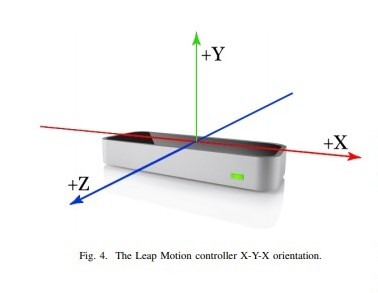

The participants are on the X axis. From the perspective of the participants, axis Z is horizontal.

In [49]:
#example peek
exp_Sync.head()

,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Distance
0,139151,-125.4162,204.0728,59.67963,9.441556,-238.5696,113.81160,127.3543,211.9258,29.63082,147.243400,-398.7635,339.9724,254.671408
1,139153,-124.9752,199.2501,61.22840,26.644800,-258.3419,77.43543,129.6168,205.7767,34.64285,134.008300,-357.7596,283.5841,256.059513
2,139155,-123.8922,194.2541,61.82588,75.630860,-292.7460,21.99517,131.2827,199.8666,39.22730,96.875100,-336.7581,274.5948,256.235098
3,139157,-122.5534,189.0004,61.86058,107.883700,-332.1241,-34.70965,131.7767,193.7695,43.56876,15.791090,-353.8951,248.1644,255.031635
4,139159,-120.2252,183.4484,60.36283,126.139900,-319.4082,-89.99706,131.9514,188.5041,47.34388,-3.345557,-287.3118,199.4683,252.563043


Text(0.5, 1.0, 'Correlation in Sync data')

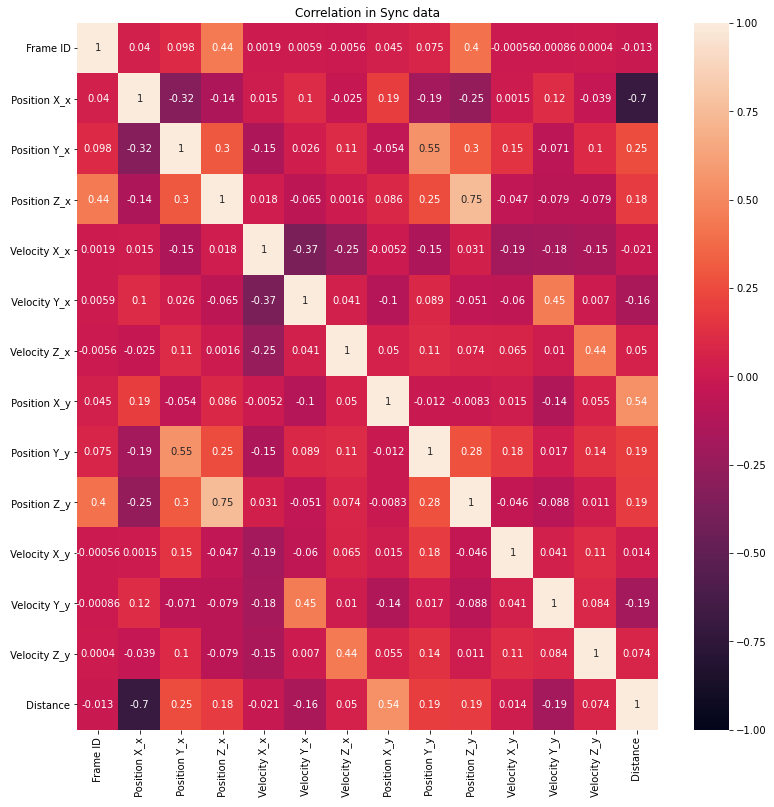

In [50]:
# find correlations
# Sync data
import seaborn as sns
plt.figure(figsize=(13,13))
sns.heatmap(exp_Sync.corr(),annot=True,vmin=-1,vmax=1)
plt.title('Correlation in Sync data')

There is high correlation between Position Y (hight) and position Z (lrft-right) in the Synchronized scenario.  
This probably imply that synchronized people will correct their position compared to each other.  

Position on axis X has the highest correlation with distance, probably because the position on the other axes is very close.  

Correlation in velocity is secondary to positioning, and the correlation only exist in axes Y and Z.

Text(0.5, 1.0, 'Correlation in Spon data')

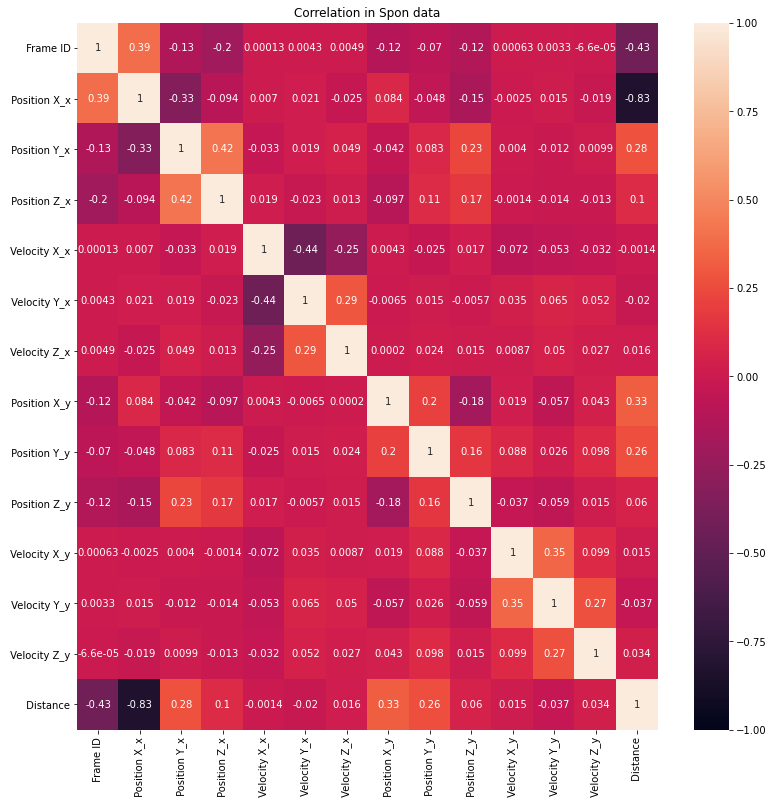

In [51]:
# Spon data
plt.figure(figsize=(13,13))
sns.heatmap(exp_Spon.corr(),annot=True,vmin=-1,vmax=1)
plt.title('Correlation in Spon data')

The correlations all decreased or disappeared, but the correlation between Distance and position X of the left hand increased.  
It seems as the right hand was pretty steady on axis X while the left hand moved a lot and changed the distance.  
Once again the X axis is the most relevant for the distance measure.

We don't expect to see any position correlation in the Alone data, the right hand data is randomly generated from the data we have so even its own movements won't be rational.

Text(0.5, 1.0, 'Correlation in Alone data')

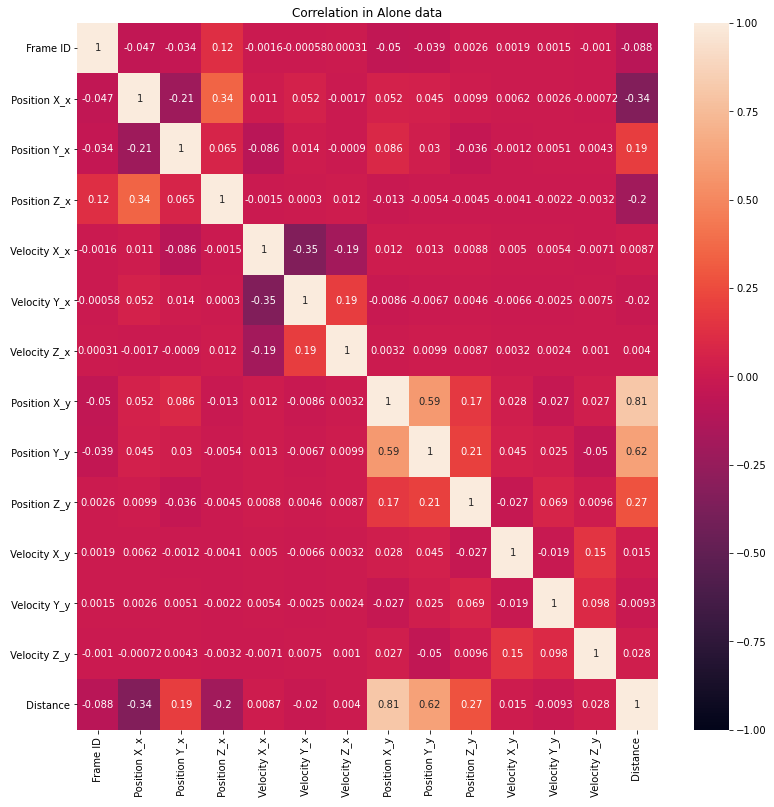

In [52]:
# Alone data
plt.figure(figsize=(13,13))
sns.heatmap(exp_Alone.corr(),annot=True,vmin=-1,vmax=1)
plt.title('Correlation in Alone data')

There is a suprising correlation between distance and right hand X and Y position. These may suggest that the right hand record has more movement compared to the left hand data.

#### Distance

In [53]:
#search for distance changes
print('Sync distance info:')
print(exp_Sync[' Distance'].describe())
print('\nSpon distance info:')
print(exp_Spon[' Distance'].describe())
print('\nAlone distance info:')
print(exp_Alone[' Distance'].describe())

Sync distance info:
count    35053.000000
mean       246.565553
std         56.823993
min         71.622821
25%        209.084688
50%        239.398479
75%        278.505061
max        479.714781
Name:  Distance, dtype: float64

Spon distance info:
count    35194.000000
mean       283.853295
std         50.393160
min        129.193006
25%        249.376555
50%        273.111131
75%        311.998844
max        805.421319
Name:  Distance, dtype: float64

Alone distance info:
count    33930.000000
mean       167.453315
std        113.938064
min          5.930047
25%        107.993413
50%        150.578382
75%        203.069746
max       1298.336799
Name:  Distance, dtype: float64


The highest mean distance is in Spon scenario, as if each person is in his personal space. The Spon scenario also has the highest minimal value.  
The Sync scenario has the the lowest maximal value, as if close distance implies connection.

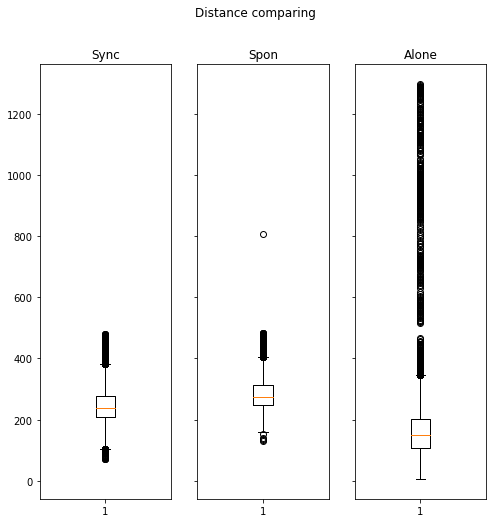

In [94]:
# compare distance data
fig, (ax1, ax2, ax3)=plt.subplots(1,3,sharey=True,figsize=(8,8))
ax1.boxplot(exp_Sync.loc[:,[' Distance']],)
ax2.boxplot(exp_Spon.loc[:,[' Distance']])
ax3.boxplot(exp_Alone.loc[:,[' Distance']])
ax1.set_title('Sync')
ax2.set_title('Spon')
ax3.set_title('Alone')
fig.suptitle('Distance comparing')
plt.show()

The maximal distance in Spon is an anomaly. We will search into it.

In [55]:
# find relevant frame ID
exp_Spon.loc[exp_Spon[' Distance']>600]

,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Distance
510,46475,-150.8155,282.1212,13.78106,-140.5987,153.9329,279.5949,-871.4965,585.8192,206.3685,-155.3215,277.2646,230.8907,805.421319


In [56]:
exp_Spon[(exp_Spon[' Frame ID']<46480) & (exp_Spon[' Frame ID']>46470)]

,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Position X_y,Position Y_y,Position Z_y,Velocity X_y,Velocity Y_y,Velocity Z_y,Distance
508,46471,-147.03190,276.9629,4.383965,-119.286500,149.035800,242.52120,142.8068,258.0320,128.664600,55.17460,92.23254,-56.703010,315.928041
509,46473,-148.60860,279.8686,9.024150,-69.170130,119.332700,274.49840,144.0893,259.9744,127.629800,75.82257,101.53770,-67.127860,316.441369
510,46475,-150.81550,282.1212,13.781060,-140.598700,153.932900,279.59490,-871.4965,585.8192,206.368500,-155.32150,277.26460,230.890700,805.421319
1213,46472,-89.99447,169.2473,55.674270,29.511430,111.251900,80.90202,145.8721,190.2721,-7.441780,-150.09160,494.55720,-47.461200,245.068800
1214,46474,-90.01333,171.3365,56.806240,-8.864284,116.857100,62.09276,144.2495,199.7804,-7.738305,-64.45657,598.27230,-19.916130,244.651032
1215,46476,-91.27477,171.9308,57.333070,-51.309100,5.388458,17.19945,143.0801,211.2798,-8.545925,-87.02306,634.56360,-15.345840,246.598035
1216,46478,-92.29958,171.6844,57.613320,-51.852580,-20.917430,16.49068,141.8339,222.7645,-8.883415,-61.53399,655.41440,-6.727804,248.695555
32,46471,-93.57275,187.3862,17.905890,135.961500,53.827130,94.24628,185.7796,268.9972,130.220700,-55.74526,-33.75988,300.379700,311.949847
33,46473,-90.54839,187.5221,19.879800,209.215500,-19.636960,113.57260,184.1923,267.5434,134.584800,-87.40683,-97.93397,229.298800,308.290597
34,46475,-86.88762,187.7104,21.869850,182.988200,55.283550,118.41640,182.3400,265.3954,137.633300,-93.50275,-139.66790,149.357400,303.182531


Our anomaly is in the 3rd row. We can see that this frame is the last in its dataset (before merging), the fast motion captured by the sensor was probably the hand that retracted from the engagement.  
We will delete this line to get better normalization.

In [60]:
(Spon[' Distance']>600).value_counts()

False    35193
True         1
Name:  Distance, dtype: int64

In [100]:
# drop line
print ('length berofe: '+str(len(Spon)))
Spon=Spon[Spon[' Distance']<600]
exp_Spon=exp_Spon[exp_Spon[' Distance']<600]
print ('length after: '+str(len(Spon)))

length berofe: 35193
length after: 35193


In [88]:
Spon.loc[Spon[' Distance']>600]

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Distance


#### Position

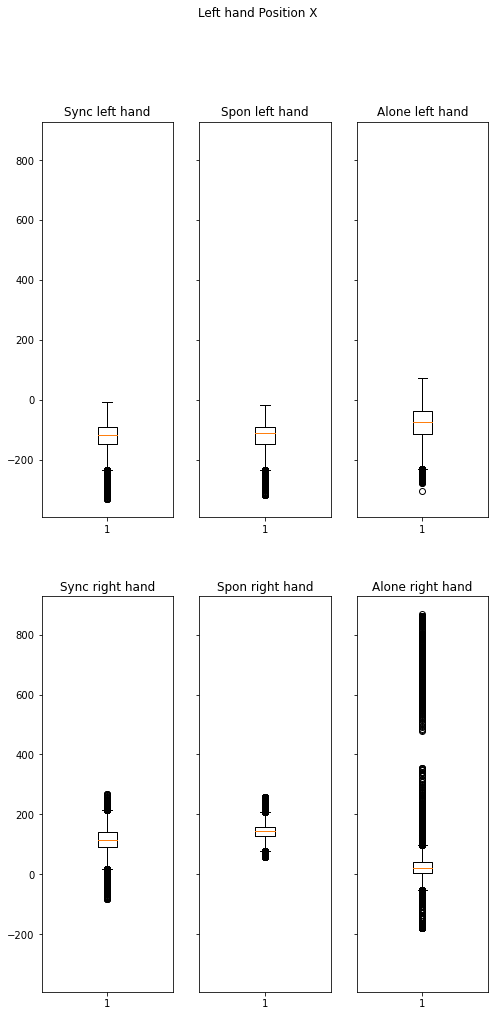

In [108]:
# difference in X axis position
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2,3,sharey=True,figsize=(8,16))
ax1.boxplot(exp_Sync.loc[:,[' Position X_x']])
ax2.boxplot(exp_Spon.loc[:,[' Position X_x']])
ax3.boxplot(exp_Alone.loc[:,[' Position X_x']])
ax4.boxplot(exp_Sync.loc[:,[' Position X_y']])
ax5.boxplot(exp_Spon.loc[:,[' Position X_y']])
ax6.boxplot(exp_Alone.loc[:,[' Position X_y']])
ax1.set_title('Sync left hand')
ax2.set_title('Spon left hand')
ax3.set_title('Alone left hand')
ax4.set_title('Sync right hand')
ax5.set_title('Spon right hand')
ax6.set_title('Alone right hand')
fig.suptitle('Left hand Position X')
plt.show()

The hands were on average closer to the sensor in the Alone scenario.

As we saw before, The distance in the Y and Z axes may be relevant to identify the scenario.

In [102]:
# add Z distance and Y distance
exp_Sync['Y Distance']=((exp_Sync[' Position Y_x']-exp_Sync[' Position Y_y'])**2)**0.5
exp_Spon['Y Distance']=((exp_Spon[' Position Y_x']-exp_Spon[' Position Y_y'])**2)**0.5
exp_Alone['Y Distance']=((exp_Alone[' Position Y_x']-exp_Alone[' Position Y_y'])**2)**0.5
exp_Sync['Z Distance']=((exp_Sync[' Position Z_x']-exp_Sync[' Position Z_y'])**2)**0.5
exp_Spon['Z Distance']=((exp_Spon[' Position Z_x']-exp_Spon[' Position Z_y'])**2)**0.5
exp_Alone['Z Distance']=((exp_Alone[' Position Z_x']-exp_Alone[' Position Z_y'])**2)**0.5

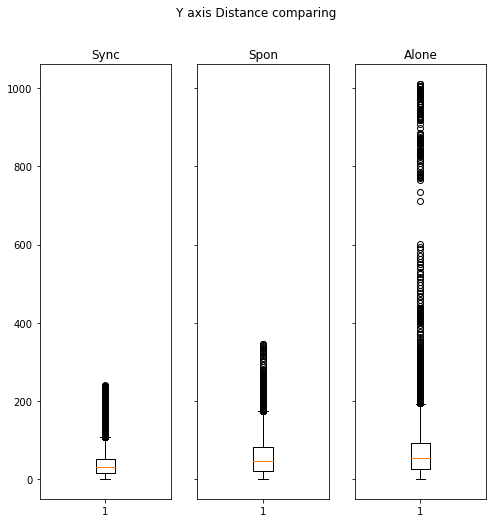

In [106]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,sharey=True,figsize=(8,8))
ax1.boxplot(exp_Sync.loc[:,['Y Distance']],)
ax2.boxplot(exp_Spon.loc[:,['Y Distance']])
ax3.boxplot(exp_Alone.loc[:,['Y Distance']])
ax1.set_title('Sync')
ax2.set_title('Spon')
ax3.set_title('Alone')
fig.suptitle('Y axis Distance comparing')
plt.show()

The distance on axis Y (hight) tend to be smaller in Sync scenario.

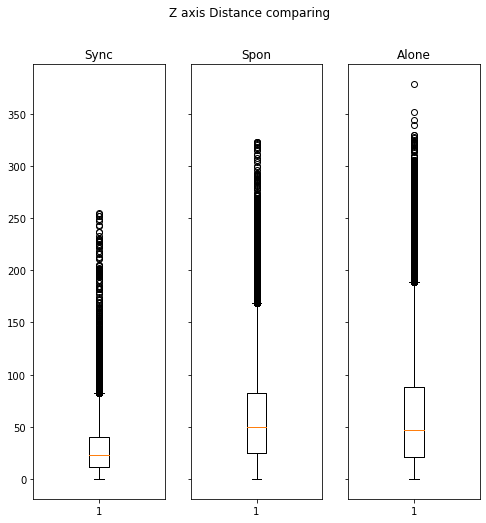

In [107]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,sharey=True,figsize=(8,8))
ax1.boxplot(exp_Sync.loc[:,['Z Distance']],)
ax2.boxplot(exp_Spon.loc[:,['Z Distance']])
ax3.boxplot(exp_Alone.loc[:,['Z Distance']])
ax1.set_title('Sync')
ax2.set_title('Spon')
ax3.set_title('Alone')
fig.suptitle('Z axis Distance comparing')
plt.show()

The distance on axis Z (horizontal) tend to be smaller in Sync scenario.

#### Velocity

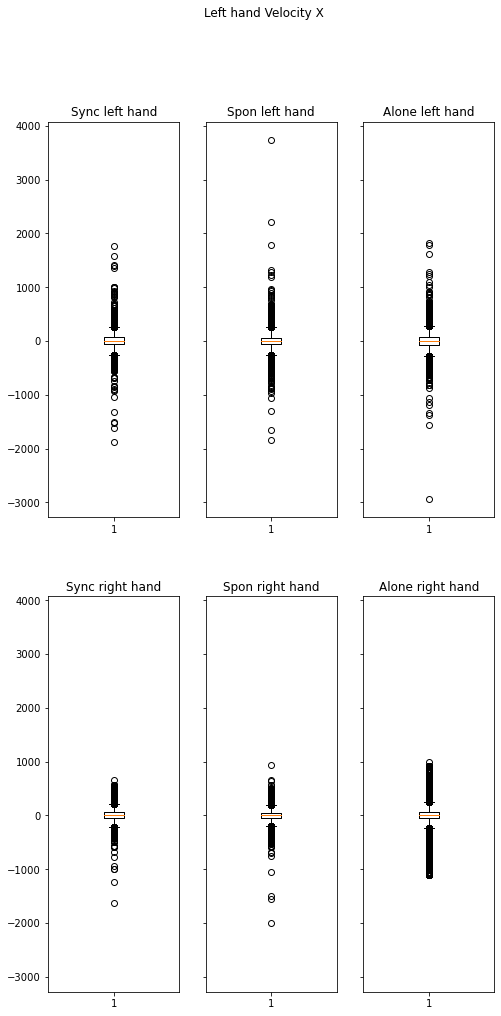

In [110]:
# difference in X axis velocity
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2,3,sharey=True,figsize=(8,16))
ax1.boxplot(exp_Sync.loc[:,[' Velocity X_x']])
ax2.boxplot(exp_Spon.loc[:,[' Velocity X_x']])
ax3.boxplot(exp_Alone.loc[:,[' Velocity X_x']])
ax4.boxplot(exp_Sync.loc[:,[' Velocity X_y']])
ax5.boxplot(exp_Spon.loc[:,[' Velocity X_y']])
ax6.boxplot(exp_Alone.loc[:,[' Velocity X_y']])
ax1.set_title('Sync left hand')
ax2.set_title('Spon left hand')
ax3.set_title('Alone left hand')
ax4.set_title('Sync right hand')
ax5.set_title('Spon right hand')
ax6.set_title('Alone right hand')
fig.suptitle('Left hand Velocity X')
plt.show()

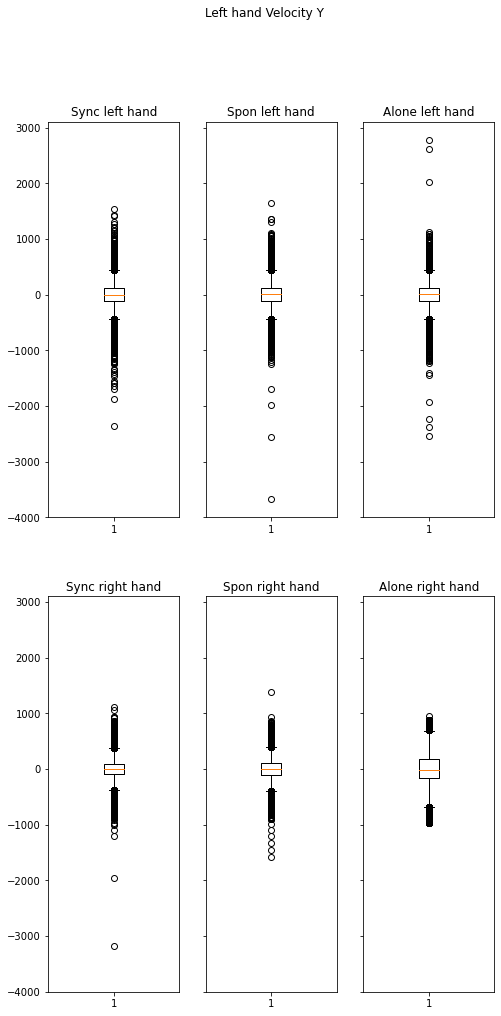

In [111]:
# difference in Y axis velocity
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2,3,sharey=True,figsize=(8,16))
ax1.boxplot(exp_Sync.loc[:,[' Velocity Y_x']])
ax2.boxplot(exp_Spon.loc[:,[' Velocity Y_x']])
ax3.boxplot(exp_Alone.loc[:,[' Velocity Y_x']])
ax4.boxplot(exp_Sync.loc[:,[' Velocity Y_y']])
ax5.boxplot(exp_Spon.loc[:,[' Velocity Y_y']])
ax6.boxplot(exp_Alone.loc[:,[' Velocity Y_y']])
ax1.set_title('Sync left hand')
ax2.set_title('Spon left hand')
ax3.set_title('Alone left hand')
ax4.set_title('Sync right hand')
ax5.set_title('Spon right hand')
ax6.set_title('Alone right hand')
fig.suptitle('Left hand Velocity Y')
plt.show()

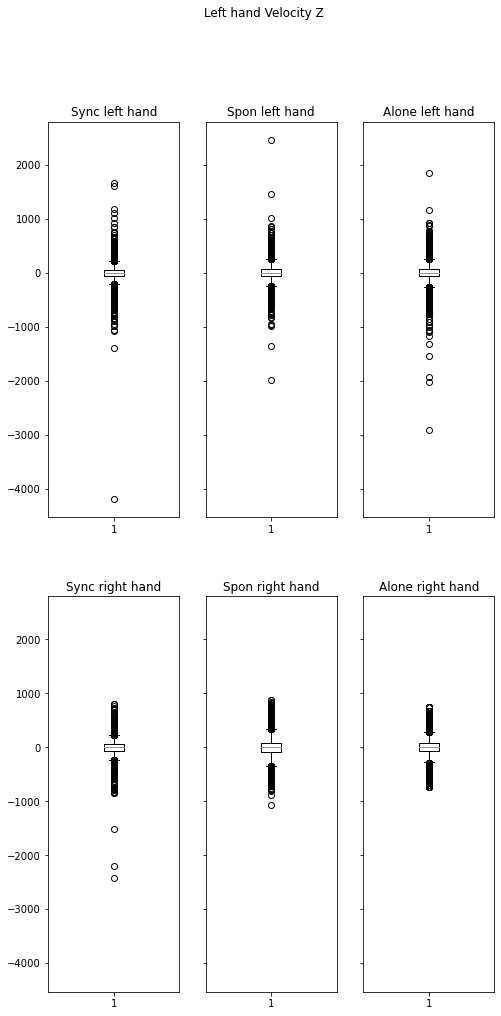

In [112]:
# difference in Z axis velocity
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2,3,sharey=True,figsize=(8,16))
ax1.boxplot(exp_Sync.loc[:,[' Velocity Z_x']])
ax2.boxplot(exp_Spon.loc[:,[' Velocity Z_x']])
ax3.boxplot(exp_Alone.loc[:,[' Velocity Z_x']])
ax4.boxplot(exp_Sync.loc[:,[' Velocity Z_y']])
ax5.boxplot(exp_Spon.loc[:,[' Velocity Z_y']])
ax6.boxplot(exp_Alone.loc[:,[' Velocity Z_y']])
ax1.set_title('Sync left hand')
ax2.set_title('Spon left hand')
ax3.set_title('Alone left hand')
ax4.set_title('Sync right hand')
ax5.set_title('Spon right hand')
ax6.set_title('Alone right hand')
fig.suptitle('Left hand Velocity Z')
plt.show()

There are many outliers in every axis, this will probably show up in the test set as well so we won't remove them.

### Data Skipping
We dont need 60 frames every second because human hands doesn't move very fast. The difference between consecutive frames will be very small.  
Instead, we will reduce the data to 6 frames per second, allowing faster model training while keeping major details about hands movement.